In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from pathlib import Path
from scipy.stats import norm

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from datetime import datetime
import joblib

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)

In [449]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = {c: [v[0] / 2, v[1] / 2] for (c, v) in configs.DEFAULT_MOVEMENT_RANGES.items()}

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["kl_divergence", "fwhm", "peak_distance", "log_weighted_sum_intensity", "negative_log_peak_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [450]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

In [451]:
def print_beam_attributes(loss_parameters, hist, dw, title, calc_params = None):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
        "negative_log_peak_intensity": lambda dw: -np.log(opt_common._get_peak_intensity_from_dw(dw))
    }
    

    wsum_fn = lambda hist: opt_common._get_weighted_sum_intensity_from_hist(hist, 2)
    if calc_params is not None:
        wsum_fn = lambda hist: opt_common._get_weighted_sum_intensity_from_hist(hist, 2, 
                                                                                calculate_over_noise=calc_params.calculate_over_noise,
                                                                                noise_threshold=calc_params.noise_threshold)
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(wsum_fn(hist)),
        "kl_divergence": lambda hist: opt_common._get_kl_divergence_with_gaussian_from_hist(hist, ref_fwhm=(5e-3, 5e-3),
                                                                                            calculate_over_noise=calc_params.calculate_over_noise,
                                                                                            noise_threshold=calc_params.noise_threshold)
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        elif ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        else:
            raise ValueError
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [452]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 512,
    nbins_v = 512,
    use_denoised = False,
    random_seed = 111,
    add_noise = True,
    calculate_over_noise= True,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=20
   )

xrange_plot = [x/4 for x in cp.xrange]
yrange_plot = [y/4 for y in cp.yrange]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot)#, nbins_h = cp.nbins_h // 4, nbins_v = cp.nbins_v // 4)


In [453]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=512, nbins_v=512, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=None, percentage_fluctuation=20, calculate_over_noise=True, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)


In [454]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-12.5, 12.5], 'hb_2': [-12.5, 12.5], 'hb_pitch': [-0.001, 0.001], 'hb_trans': [-0.015, 0.015], 'vb_bender': [-10.0, 10.0], 'vb_pitch': [-0.001, 0.001], 'vb_trans': [-0.015, 0.015]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'loss_parameters': ['kl_divergence', 'fwhm', 'peak_distance', 'log_weighted_sum_intensity', 'negative_log_peak_intensity'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [481]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


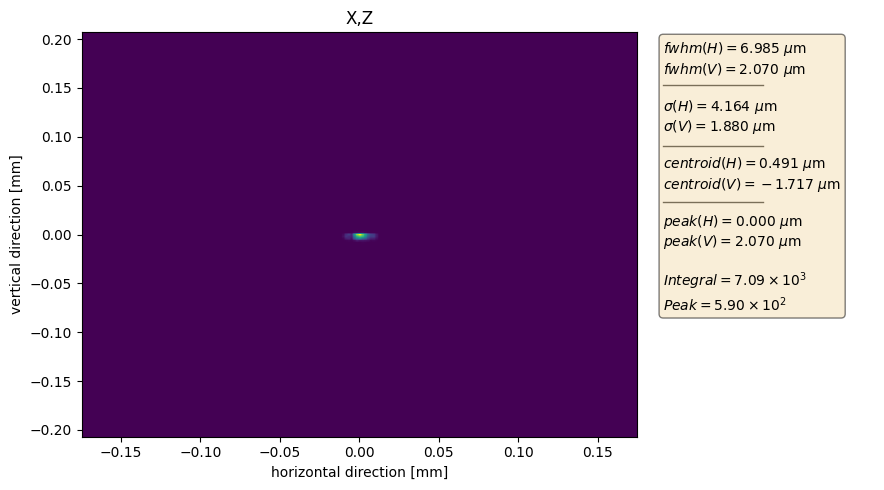

In [482]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [483]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam", calc_params=cp)

Focused beam system kl_divergence: 1.786e+00
Focused beam system fwhm: 5.484e-03
Focused beam system peak_distance: 2.126e-03
Focused beam system log_weighted_sum_intensity: -1.709e+00
Focused beam system negative_log_peak_intensity: -7.113e+00


In [484]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [485]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-161.7, -171.9, 0.17128733853924988, -0.0248, 423.5, 0.17267733853924988, -0.0043]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [6.319093680343563, -10.871214827399566, -0.0006485746194956092, -0.012356122498640595, 4.475540072320124, 0.0007882019490090715, -0.004313808126171026]


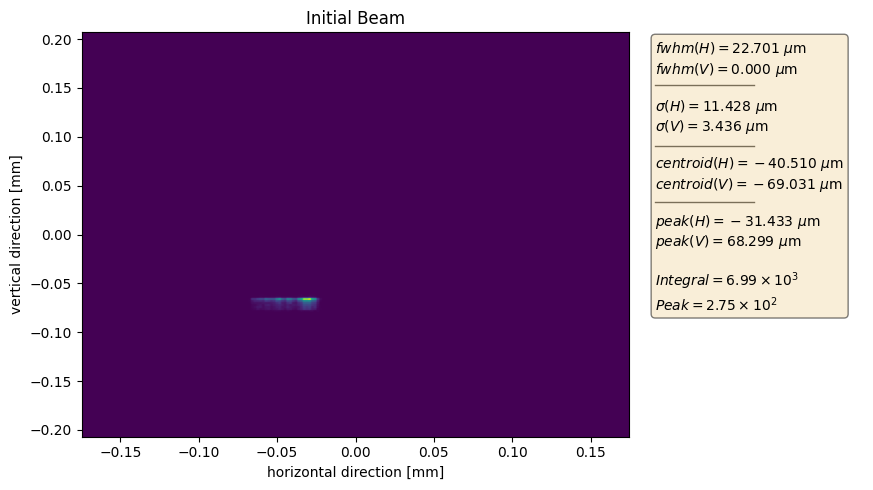

Perturbed beam system kl_divergence: 1.457e+01
Perturbed beam system fwhm: 8.227e-03
Perturbed beam system peak_distance: 7.371e-02
Perturbed beam system log_weighted_sum_intensity: 3.824e+00
Perturbed beam system negative_log_peak_intensity: -6.301e+00


In [486]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

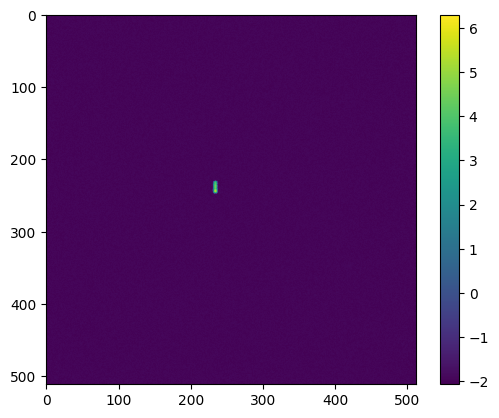

In [487]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [488]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### WITH MOO THRESHOLDS

In [489]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

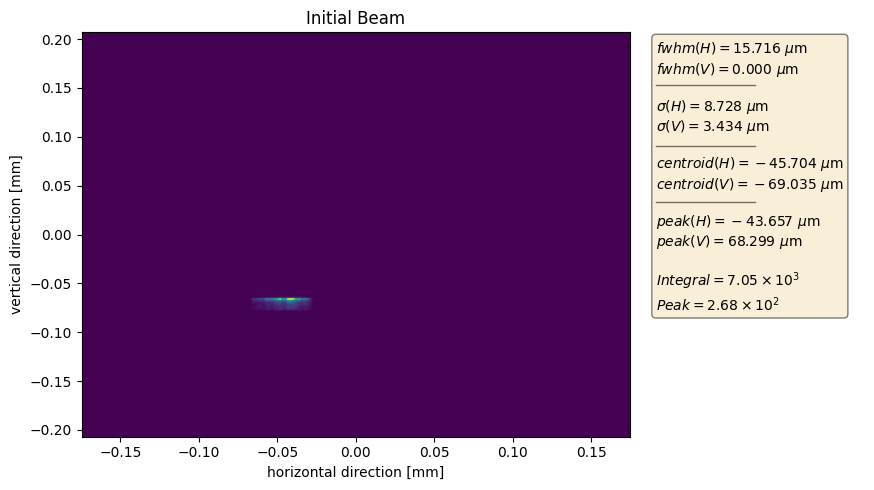

In [490]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [491]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

Perturbed beam system kl_divergence: 1.467e+01
Perturbed beam system fwhm: 1.371e-02
Perturbed beam system peak_distance: 7.903e-02
Perturbed beam system log_weighted_sum_intensity: 3.891e+00
Perturbed beam system negative_log_peak_intensity: -6.365e+00


In [492]:
opt_params = OptimizationParameters()

In [493]:
opt_params.params["multi_objective_optimization"]

True

In [494]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={'fwhm':(5e-3,5e-3)})

In [495]:
moo_thresholds

{'fwhm': 0.02,
 'kl_divergence': 13.50200431180333,
 'peak_distance': 0.0959993038946981,
 'log_weighted_sum_intensity': 4.552125026644606,
 'negative_log_peak_intensity': -5.0956780005180615}

In [496]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [497]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-01-22 17:49:55,904] A new study created in memory with name: no-name-ca02929a-ac23-4f69-9bca-e2d41eae3be3


In [498]:
opt_trial.trials(50)#, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hb_1' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hb_2' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(
[I 2023-01-22 17:50:04,779] Trial 0 finished with values: [14.672498359583896, 0

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:05,203] Trial 1 finished with values: [14.684401294499345, 0.0050234071247137625, 0.07664707631247902, 3.597456219035235, -6.574157076463869] and parameters: {'hb_1': 2.5, 'hb_2': -8.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.008, 'vb_bender': -4.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.0144}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:05,621] Trial 2 finished with values: [14.248306009137146, 0.033436452232415724, 0.1139051510604782, 4.292400353251383, -5.9062459696772045] and parameters: {'hb_1': -2.5, 'hb_2': -6.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.014700000000000001, 'vb_bender': -6.0, 'vb_pitch': -0.00084, 'vb_trans': 0.005000000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:06,040] Trial 3 finished with values: [13.774544353646831, 0.002710667313625214, 0.12089326353276486, 4.78800316735791, -5.78804762353817] and parameters: {'hb_1': 3.5, 'hb_2': -5.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.0115, 'vb_bender': -9.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': 0.008800000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:06,460] Trial 4 finished with values: [13.612771762405384, 0.00831250367128669, 0.07060779927861884, 3.9662641339556077, -5.463257337412657] and parameters: {'hb_1': 8.5, 'hb_2': 8.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0023, 'vb_bender': 7.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': -0.014199999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:06,881] Trial 5 finished with values: [14.037876743582304, 0.005950689503444631, 0.01913536957506735, 2.0777752239543505, -6.210393135480032] and parameters: {'hb_1': -1.5, 'hb_2': -10.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.0059000000000000025, 'vb_bender': 1.0, 'vb_pitch': -0.00046, 'vb_trans': 0.0149}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:07,304] Trial 6 finished with values: [13.997096052728534, 0.01397047144034955, 0.07213656645114426, 3.74270951643617, -5.303784137722328] and parameters: {'hb_1': -9.5, 'hb_2': 3.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.002899999999999998, 'vb_bender': 5.0, 'vb_pitch': -0.00035999999999999997, 'vb_trans': -0.002999999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:07,725] Trial 7 finished with values: [14.760979468015217, 0.0018157971088822323, 0.12359810957712922, 4.755257924148501, -6.375399626372549] and parameters: {'hb_1': -4.5, 'hb_2': 11.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': 0.009400000000000002, 'vb_bender': -10.0, 'vb_pitch': 0.0008800000000000001, 'vb_trans': 0.013500000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:08,150] Trial 8 finished with values: [14.480571098722354, 0.03617516605573703, 0.048235264717104015, 3.2422195604137256, -5.642398823099132] and parameters: {'hb_1': 7.5, 'hb_2': -0.5, 'hb_pitch': 0.0009, 'hb_trans': -0.0024999999999999988, 'vb_bender': -4.0, 'vb_pitch': -0.00098, 'vb_trans': -0.0139}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:08,576] Trial 9 finished with values: [13.820837309505869, 0.014302775848507691, 0.1482201694884623, 5.038174175616355, -5.8745722188432685] and parameters: {'hb_1': -11.5, 'hb_2': -9.5, 'hb_pitch': -0.001, 'hb_trans': -0.008299999999999998, 'vb_bender': 1.0, 'vb_pitch': -0.00066, 'vb_trans': -0.0097}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:16,766] Trial 10 finished with values: [13.894202257152912, 0.005950689503444631, 0.03159365171573797, 2.673063995038157, -5.9099286732280065] and parameters: {'hb_1': -0.5, 'hb_2': -11.5, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.0046, 'vb_bender': 2.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:27,778] Trial 11 finished with values: [13.814349212168995, 0.00888498351877513, 0.017493016620730786, 2.1014657261058676, -5.8329696407947855] and parameters: {'hb_1': -4.5, 'hb_2': -10.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.0059000000000000025, 'vb_bender': 2.0, 'vb_pitch': -0.00043999999999999996, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:50:43,779] Trial 12 finished with values: [12.810723641676283, 0.006154346152313786, 0.014883065225052403, 1.7848353848173986, -5.7128645372210825] and parameters: {'hb_1': -2.5, 'hb_2': -9.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.002700000000000001, 'vb_bender': 1.0, 'vb_pitch': -0.00076, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:51:03,833] Trial 13 finished with values: [10.109245700572176, 0.0050234071247137625, 0.013281117301726797, 1.1625881403818619, -6.099053205823326] and parameters: {'hb_1': 0.5, 'hb_2': -8.5, 'hb_pitch': 0.0005, 'hb_trans': 0.005400000000000002, 'vb_bender': 0.0, 'vb_pitch': -0.00078, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:51:16,612] Trial 14 finished with values: [12.328037570955109, 0.005486138649829795, 0.022113179125581174, 1.7334477384191216, -6.370662703901332] and parameters: {'hb_1': 3.5, 'hb_2': -8.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.0069, 'vb_bender': 0.0, 'vb_pitch': -0.00076, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:51:32,629] Trial 15 finished with values: [8.067241354178242, 0.0018157971088822323, 0.005064140901603024, 0.8873712690913861, -6.201965857169485] and parameters: {'hb_1': 2.5, 'hb_2': -10.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.0051, 'vb_bender': -1.0, 'vb_pitch': -0.00074, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:51:42,437] Trial 16 finished with values: [7.421866268618304, 0.002856609403673588, 0.002126152175007474, 0.9716785745029028, -6.185462186873542] and parameters: {'hb_1': 4.5, 'hb_2': -11.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.007000000000000003, 'vb_bender': -1.0, 'vb_pitch': -0.00066, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:51:54,115] Trial 17 finished with values: [13.064308602257256, 0.005486138649829795, 0.012095854977702155, 1.0712491526708952, -6.450108660848825] and parameters: {'hb_1': 4.5, 'hb_2': -8.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.005200000000000003, 'vb_bender': -2.0, 'vb_pitch': -0.00052, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:52:08,355] Trial 18 finished with values: [8.02249195599087, 0.002856609403673588, 0.00442263582511622, 0.9068227917310759, -6.442804781703807] and parameters: {'hb_1': 4.5, 'hb_2': -11.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.004100000000000003, 'vb_bender': -3.0, 'vb_pitch': -0.00068, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:52:26,436] Trial 19 finished with values: [10.68080325033517, 0.0018157971088822323, 0.012446379745709724, 1.1051802703468165, -5.996784941148443] and parameters: {'hb_1': 6.5, 'hb_2': -12.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.0023, 'vb_bender': -1.0, 'vb_pitch': -0.0007, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:52:49,148] Trial 20 finished with values: [8.477056412156765, 0.005950689503444631, 0.00442263582511622, 1.0610234783058947, -6.569559842773621] and parameters: {'hb_1': 1.5, 'hb_2': -12.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.0057, 'vb_bender': -3.0, 'vb_pitch': -0.0007, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:53:15,379] Trial 21 finished with values: [7.199564641868176, 0.005486138649829795, 0.002126152175007474, 0.8068061144158447, -6.603823768033972] and parameters: {'hb_1': 3.5, 'hb_2': -10.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.005500000000000001, 'vb_bender': -3.0, 'vb_pitch': -0.0007, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(
[I 2023-01-22 17:53:37,707] Trial 22 finished with values: [7.558974859345754, 0.005486138649829795, 0.002126152175007474, 0.8143438322933423, -6.63378358743513] and parameters: {'hb_1': 3.5, 'hb_2': -10.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.0045000000000000005, 'vb_bender': -3.0, 'vb_pitch': -0.00068, 'vb_trans': 0

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:54:03,147] Trial 23 finished with values: [7.161997191495578, 0.0018157971088822323, 0.00442263582511622, 0.7550598624693008, -6.368140975083802] and parameters: {'hb_1': 2.5, 'hb_2': -10.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.0025000000000000022, 'vb_bender': -3.0, 'vb_pitch': -0.00068, 'vb_trans': 0.0148}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(
[I 2023-01-22 17:54:33,134] Trial 24 finished with values: [8.381747231292, 0.0018157971088822323, 0.0070454294959375096, 0.7675467043511232, -6.308235231818156] and parameters: {'hb_1': 2.5, 'hb_2': -10.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.0006000000000000016, 'vb_bender': -5.0, 'vb_pitch': -0.00068, 'vb_trans':

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:55:45,844] Trial 26 finished with values: [9.129652128548194, 0.005486138649829795, 0.0070454294959375096, 0.7872004950046411, -6.66302541277921] and parameters: {'hb_1': 3.5, 'hb_2': -10.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.0011999999999999997, 'vb_bender': -3.0, 'vb_pitch': -0.0007, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:56:26,815] Trial 27 finished with values: [8.766352648643394, 0.005950689503444631, 0.008412079218732188, 0.8321120664135832, -6.518965985297268] and parameters: {'hb_1': 0.5, 'hb_2': -10.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': -0.000899999999999998, 'vb_bender': -3.0, 'vb_pitch': -0.00066, 'vb_trans': 0.011500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:57:16,098] Trial 28 finished with values: [9.265003724233923, 0.015050146078116812, 0.008412079218732188, 1.0538038535673246, -6.504720778928718] and parameters: {'hb_1': 1.5, 'hb_2': -12.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 1.734723475976807e-18, 'vb_bender': -4.0, 'vb_pitch': -0.00062, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:57:55,320] Trial 29 finished with values: [8.200953137559145, 0.0050234071247137625, 0.0070454294959375096, 0.5267219112892959, -6.606350377582254] and parameters: {'hb_1': 2.5, 'hb_2': -8.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.0005000000000000004, 'vb_bender': -4.0, 'vb_pitch': -0.00068, 'vb_trans': 0.013800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:58:48,526] Trial 30 finished with values: [10.339841671597842, 0.022490063995365194, 0.012446379745709724, 0.7598891364387903, -6.179416130088236] and parameters: {'hb_1': 6.5, 'hb_2': -9.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.002400000000000003, 'vb_bender': -3.0, 'vb_pitch': -0.00068, 'vb_trans': 0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:59:24,598] Trial 31 finished with values: [9.482965846802248, 0.0018157971088822323, 0.0070454294959375096, 1.1595910233372133, -6.349098349056559] and parameters: {'hb_1': 3.5, 'hb_2': -12.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.0086, 'vb_bender': -3.0, 'vb_pitch': -0.00068, 'vb_trans': 0.011700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 17:59:57,083] Trial 32 finished with values: [6.851844891862547, 0.005486138649829795, 0.002126152175007474, 0.3064940511074568, -6.7261762328838826] and parameters: {'hb_1': 2.5, 'hb_2': -6.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.004300000000000002, 'vb_bender': -3.0, 'vb_pitch': -0.00066, 'vb_trans': 0.014300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)

KeyboardInterrupt



In [499]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 116.19361843994629
nan 2.642376164096422
nan 2.476441849205937
nan 2.127738891247039
nan 1.693372176080305
nan 1.358653384970218


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_53492/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[14.760979468015217, 0.0018157971088822323, 0.12359810957712922, 4.755257924148501, -6.375399626372549]


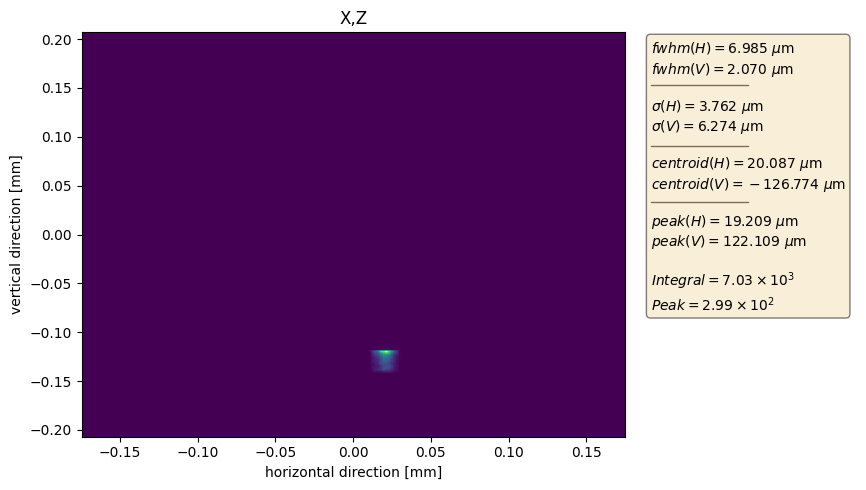

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[7.421866268618304, 0.002856609403673588, 0.002126152175007474, 0.9716785745029028, -6.185462186873542]


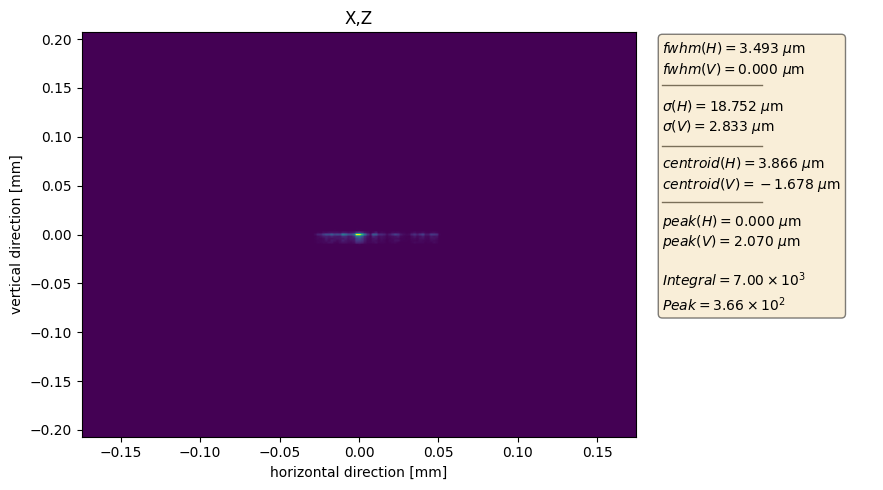

[8.02249195599087, 0.002856609403673588, 0.00442263582511622, 0.9068227917310759, -6.442804781703807]


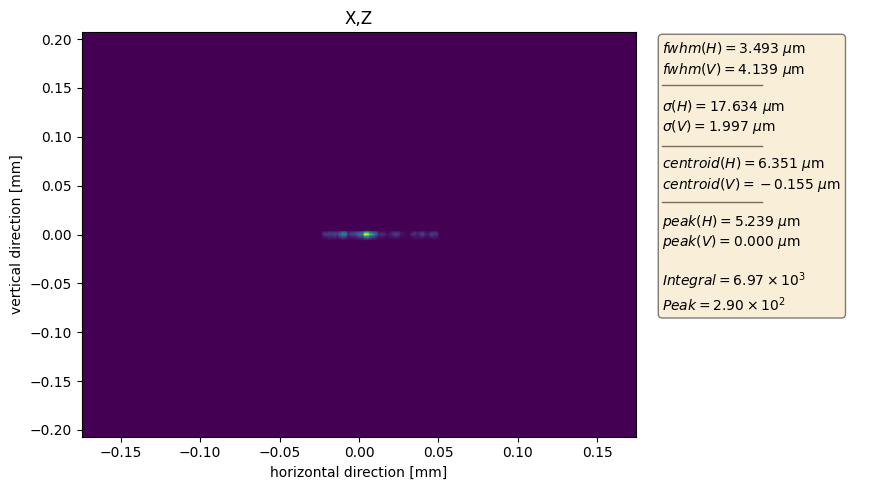

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[7.161997191495578, 0.0018157971088822323, 0.00442263582511622, 0.7550598624693008, -6.368140975083802]


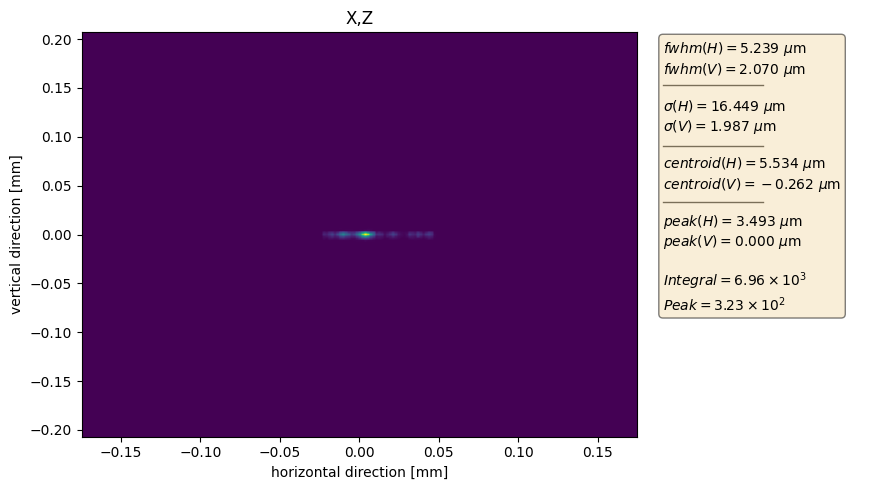

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[8.200953137559145, 0.0050234071247137625, 0.0070454294959375096, 0.5267219112892959, -6.606350377582254]


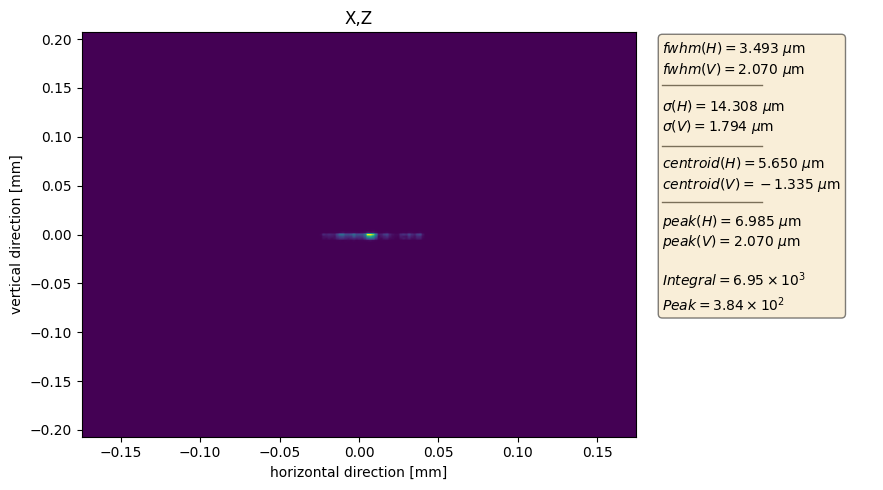

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[6.851844891862547, 0.005486138649829795, 0.002126152175007474, 0.3064940511074568, -6.7261762328838826]


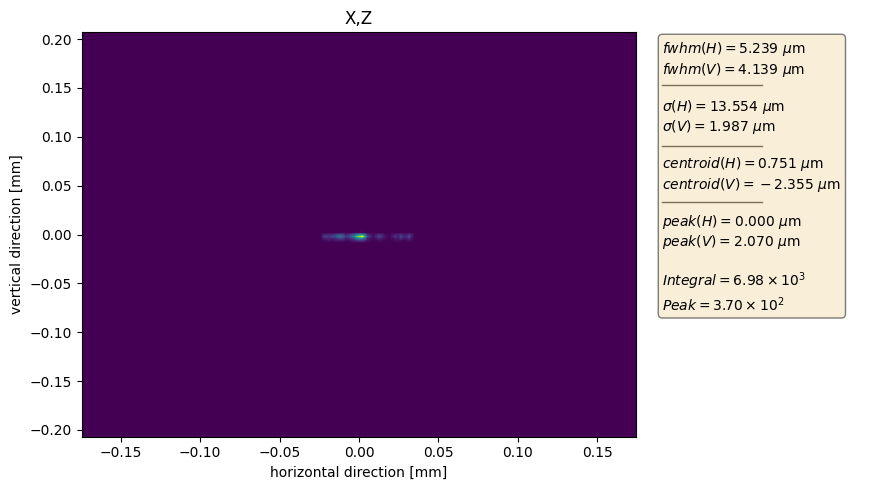

In [500]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

[6.851844891862547, 0.005486138649829795, 0.002126152175007474, 0.3064940511074568, -6.7261762328838826]


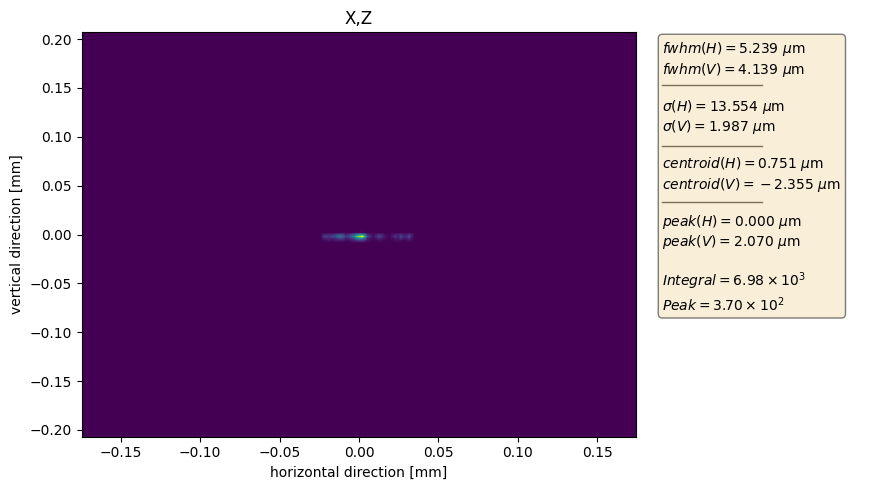

error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
CAC: error = "Network is unreachable" sending UDP msg to 172.16.15.255:5064
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"


In [501]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

In [476]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.TOPSIS)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

4
[0.39238101 0.37191152 0.376902   0.3958905  0.61722257]
4


IndexError: list index out of range

In [ ]:
opt_trial.trials(50)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35131/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

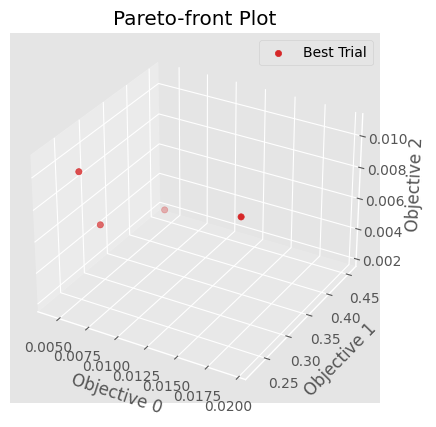

In [61]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [62]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-9.981867451434915 1.246816117983465
-11.103674825592698 1.248786231659959
-12.404106487397252 1.5740887467647389
-11.452516771582054 1.298538022835249


[0.01946850076335243, 0.2205931963086094, 0.010764786597660133]


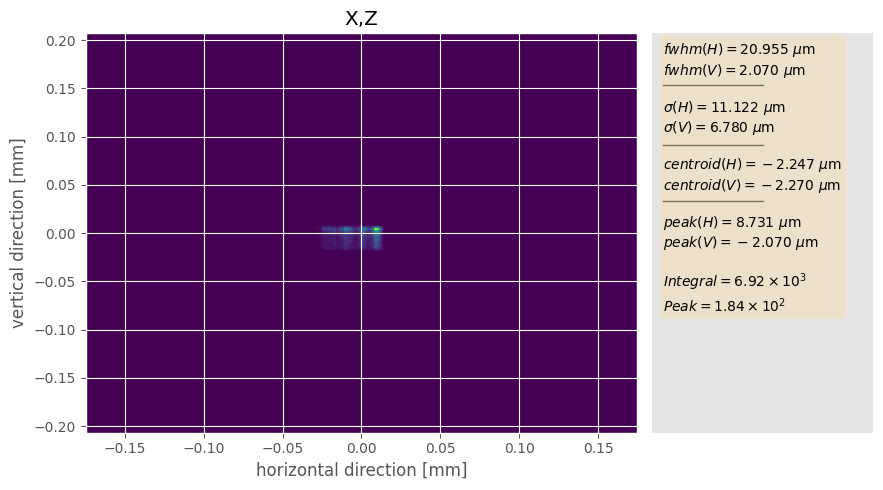

[0.006375019148255531, 0.2221720649020278, 0.010630760875037412]


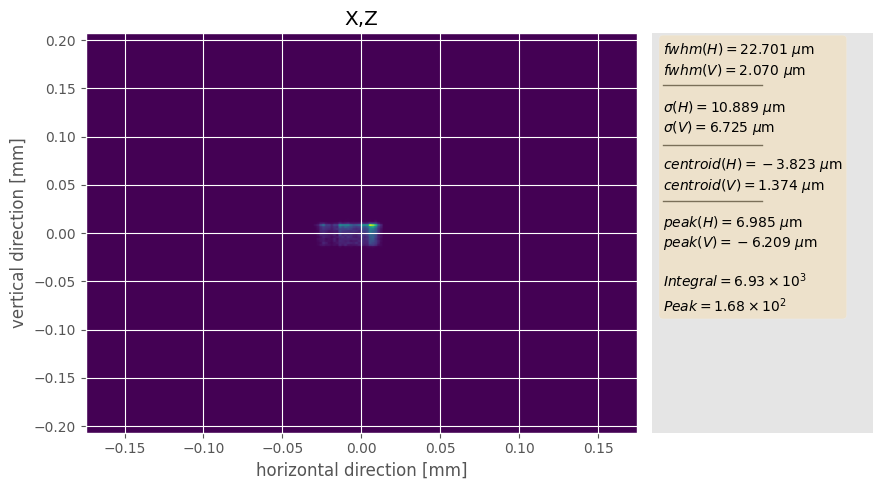

[0.004252304350014948, 0.4536765313566668, 0.002126152175007474]


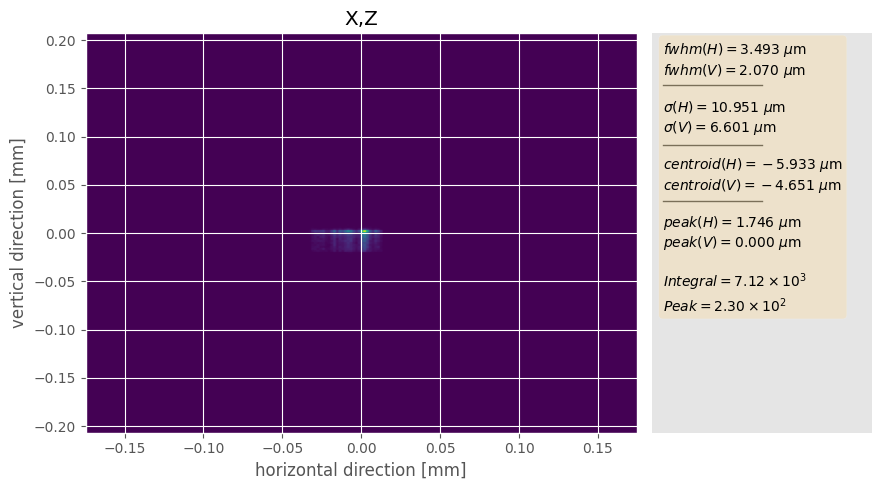

[0.006375019148255531, 0.26123903381382374, 0.006378456525022422]


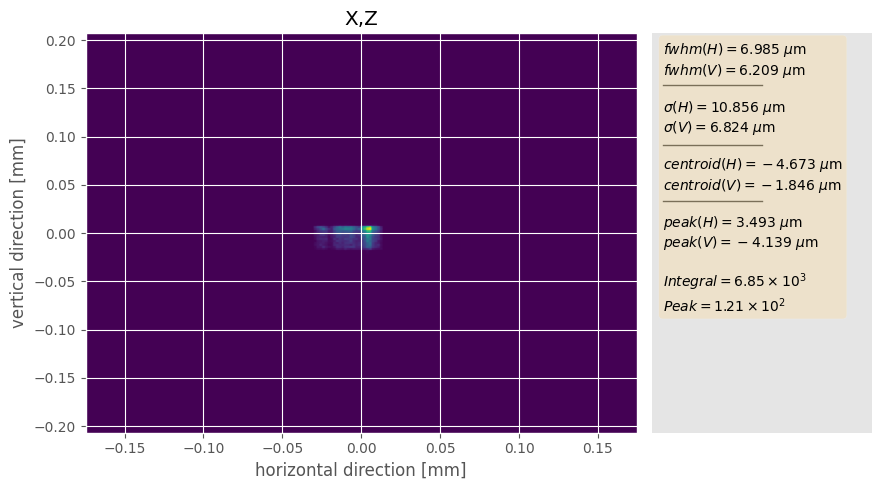

In [63]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

[0.004252304350014948, 0.4536765313566668, 0.002126152175007474]


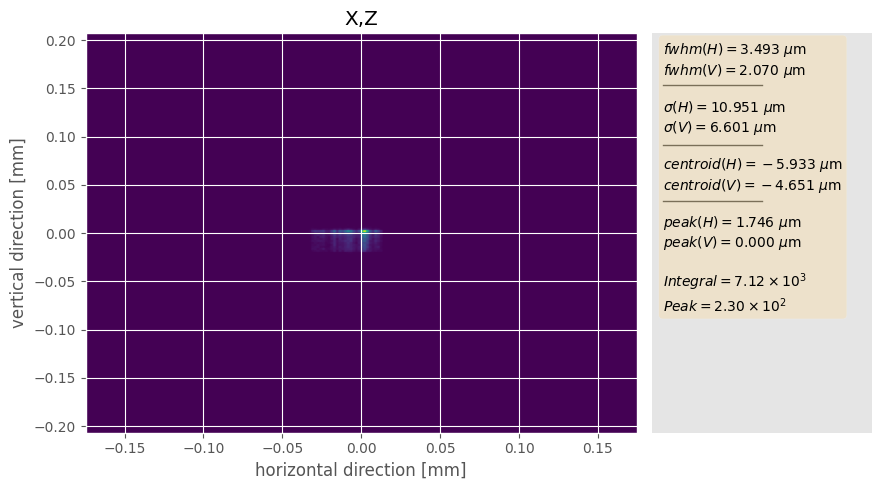

In [64]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

[0.004252304350014948, 0.4536765313566668, 0.002126152175007474]


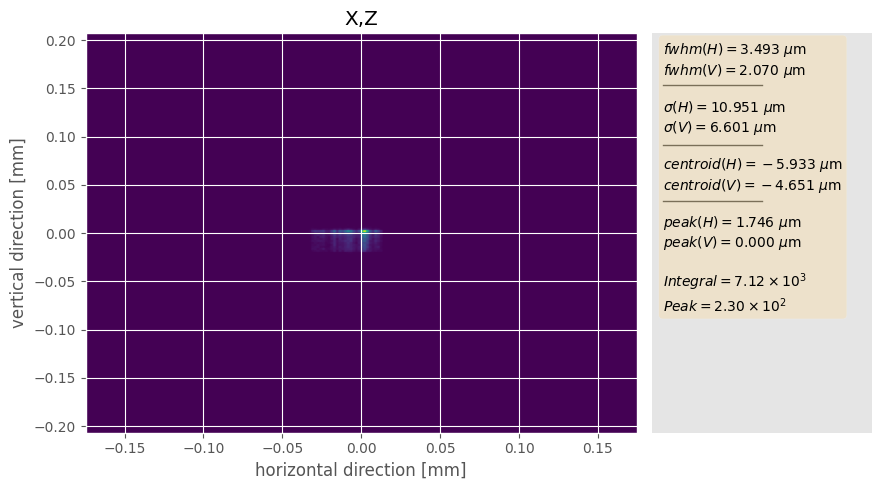

In [65]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.TOPSIS)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)